
Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016

Team 3 (AKA Team Super Awesome):  Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page:
https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

Note: Code borrowed heavily from Eric Larson's github pages for this class.
https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

Code also borrowed from other projects we're working on using the same dataset.

https://github.com/RahnL/DataScience-SMU/blob/master/DataMining/DataMining-MiniLab1-Lieberman-Melendez-Rogers.ipynb
https://github.com/rlshuhart/MSDS6210-Immersion_Project/blob/master/Study/Closing%20the%20Gap%20Study%20Revisited.ipynb


## Contents
* Intro
* Data Cleanup and Reduction

###Clean the rest of this up before submitting.
* Logistical Regression
* KNN, decision tree- Rahn
* Random Forest - Sal
* Bootstrapping - Thomas


## Data Preparation


Our team has selected the 2014 Behavioral Risk Factor Surveillance System data (BRFSS), from the Center for Disease Control and prevention (CDC), to attempt to understand the relationship between quality of health and a number of behavioral, demographic and environmental factors. 

The purpose of the BRFSS project is to survey a large population of Americans on a wide range of topics to inform policy, research and healthcare delivery. The same or similar questions are asked each year and the resulting dataset gives not only a broad, comprehensive view of health quality in the United States, but it also provides a longitudinal view on how quality of care (among other factors) is changing over time.

There are 279 variables in the dataset and over 460,000 surveys completed. The sheer breadth and complexity of this data, with missing, weighted and calculated variables requires a clear and distinct question of interest and some sense of what variables might help answer the question. We have chosen to focus on one particular question in the survey as our response variable and will attempt to better understand the impact reported behaviors have on responses to that question. 

Our response variable becomes the answer to the following question on quality of health: "Would you say that in general your health is: (1) excellent, (2) very good, (3) good, (4) fair, (5) poor?" (section 1.1, column 80)

We reduce the 279 variables to focus on those related to behavioral survey questions. The corresponding variables from the questions related to behavior number 30, so our dataset is roughly 450,000 rows by 30 columns. 

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# plot graphs in the notebook
%matplotlib inline

In [33]:
# Read the dataset, and do some initial cleanup.

df = pd.read_csv("data/LLCP2014XPT.txt", sep="\t", encoding = "ISO-8859-1")
df.head()

print("Starting length is %.f " % len(df))

df.info()
df.head()

C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Starting length is 464664 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464664 entries, 0 to 464663
Columns: 279 entries, _STATE to RCSBIRTH
dtypes: float64(226), int64(52), object(1)
memory usage: 989.1+ MB


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_FOBTFS,_CRCREC,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,1,1,1172014,1,17,2014,1100,2014000001,2014000001,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN
1,1,1,1072014,1,7,2014,1100,2014000002,2014000002,1.0,...,2.0,2.0,2.0,4,1,1,NaN,NaN,NaN,NaN
2,1,1,1092014,1,9,2014,1100,2014000003,2014000003,1.0,...,2.0,2.0,2.0,6,1,1,NaN,NaN,NaN,NaN
3,1,1,1072014,1,7,2014,1100,2014000004,2014000004,1.0,...,2.0,1.0,2.0,6,3,1,NaN,NaN,NaN,NaN
4,1,1,1162014,1,16,2014,1100,2014000005,2014000005,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN


## Data Reduction and Pre-processing

Because we're interested in the relationship between behaviors, demographics and other factors, and the impact they have on general health quality, we'll reduce the data frame down to those variables we think will have the biggest impact, including:

#### Behaviors:
- Whether someone smokes or not (represented by _SMOKER3)
- Physical activity (represented by PHYSHLTH)

#### Demographics:
- Age (represented by _AGE_G)
- Education level (represented by EDUCA)
- Income level (represented by _INCOMG)
- Race (represented by _IMPRACE, an imputed value based on the initial data ste)

#### Other Factors:
- The cost of health care (represented by MEDCOST)
- Health coverage (represented by HLTHPLN1)

In [34]:
# Age 18 to 64 - Excludes 65 or older, refused, or missing
df = df[df['_AGE65YR'] == 1].drop('_AGE65YR', axis=1)

# Exclude blank, 'Don't know', 'Not Sure', or 'Refused'
df = df[((df['GENHLTH'].notnull()) & (~df['GENHLTH'].isin([7,9])))] 

# Reduce Ethnicity to White, Black, or Hispanic (ex. Asian 2%, American Indian/Alaskan Native 1.55%, other 2.8%)
df = df[df['_IMPRACE'].isin([1,2,5])]
# Has Health plan --Excludes 'Don't know', 'Not Sure', or 'Refused'. drops .6%
df = df[df['HLTHPLN1'].isin([1,2])]

# Translate GENHLTH to binary classification of
# Combining the “excellent”, “very good” and “good” responses as measures of “good or better” (1) health 
# and the “fair” and “poor” measures as “fair and poor” (0).
df.loc[(df['GENHLTH'] < 4), 'health'] = 1
df.loc[(df['GENHLTH'] >= 4), 'health'] = 0

# Extract survey year from sequence. IYEAR sometimes went into the next year. 
# This is one way to put designate the year of the data publication
# Also, if we add  other years to the data, this seperates it.
df['Rec_Year'] = df['SEQNO'].astype(str).str[:4].astype(int)


In [27]:
# Split the variables we want to look at to a new DF, and a little more cleanup
df_reduced = df[['health','_SMOKER3','PHYSHLTH','_AGE_G','EDUCA','_INCOMG','MEDCOST','HLTHPLN1','_IMPRACE']]

# Cleanup
df_reduced.replace(7,np.nan, inplace=True)  #replace the "refused" answer choice
df_reduced.replace(9, np.nan, inplace=True) #replace the 'Don't Know' choice
df_reduced = df_reduced.dropna() # this drops those that were the refused/don't know.

df_reduced.info()
df_reduced.head(20)

C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\trogers\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 231507 entries, 2 to 464663
Data columns (total 9 columns):
health      231507 non-null float64
_SMOKER3    231507 non-null float64
PHYSHLTH    231507 non-null float64
_AGE_G      231507 non-null int64
EDUCA       231507 non-null float64
_INCOMG     231507 non-null float64
MEDCOST     231507 non-null float64
HLTHPLN1    231507 non-null int64
_IMPRACE    231507 non-null int64
dtypes: float64(6), int64(3)
memory usage: 17.7 MB


,health,_SMOKER3,PHYSHLTH,_AGE_G,EDUCA,_INCOMG,MEDCOST,HLTHPLN1,_IMPRACE
2,1.0,3.0,88.0,4,6.0,5.0,2.0,1,1
6,1.0,3.0,2.0,5,6.0,5.0,2.0,1,1
7,1.0,4.0,3.0,5,4.0,1.0,2.0,1,1
9,1.0,2.0,1.0,3,5.0,5.0,2.0,1,1
12,1.0,4.0,88.0,3,6.0,5.0,2.0,1,1
13,1.0,3.0,88.0,5,6.0,3.0,2.0,1,1
22,0.0,4.0,22.0,4,5.0,2.0,1.0,1,1
24,1.0,1.0,88.0,2,5.0,1.0,1.0,1,1
25,0.0,1.0,30.0,3,2.0,2.0,1.0,2,1
26,1.0,4.0,88.0,5,5.0,5.0,2.0,1,1


In [35]:
enc = OneHotEncoder()
enc.fit(df_reduced) 
OneHotEncoder(categorical_features='health', dtype='float64', handle_unknown='error', n_values='auto', sparse=True)

OneHotEncoder(categorical_features='health', dtype='float64',
       handle_unknown='error', n_values='auto', sparse=True)

In [87]:
df_reduced1 = df_reduced
df_reduced1.head(10)

,health,_SMOKER3,PHYSHLTH,_AGE_G,EDUCA,_INCOMG,MEDCOST,HLTHPLN1,_IMPRACE
2,1.0,3.0,88.0,4,6.0,5.0,2.0,1,1
6,1.0,3.0,2.0,5,6.0,5.0,2.0,1,1
7,1.0,4.0,3.0,5,4.0,1.0,2.0,1,1
9,1.0,2.0,1.0,3,5.0,5.0,2.0,1,1
12,1.0,4.0,88.0,3,6.0,5.0,2.0,1,1
13,1.0,3.0,88.0,5,6.0,3.0,2.0,1,1
22,0.0,4.0,22.0,4,5.0,2.0,1.0,1,1
24,1.0,1.0,88.0,2,5.0,1.0,1.0,1,1
25,0.0,1.0,30.0,3,2.0,2.0,1.0,2,1
26,1.0,4.0,88.0,5,5.0,5.0,2.0,1,1


## Logistic Regression

Here, we are performing a logistic regression test to see how accurately we can predict health based on our chosen variables.

We do 3-fold cross validation, using an 80/20 split for training and testing.


In [14]:

from sklearn.cross_validation import ShuffleSplit

# rerun with all variables, filling NaN values with zero
# Create a copy of the dataframe, so the original is still available for other models in the notebook
df_logreg = df_reduced
df_logreg = df_logreg.fillna(value=0)

#... setup x, y
if 'health' in df_logreg:
    y = df_logreg['health'].values # get the labels we want
    del df_logreg['health'] # get rid of the class label

X = df_logreg.values # use everything else to predict!

# do the cross validation
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
print (cv_object)

ShuffleSplit(231507, n_iter=3, test_size=0.2, random_state=None)


In [10]:
# run logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import datetime

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

iter_num = 0
accuracy = 0

# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set predictions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print ("====Iteration",iter_num," ====")
    print ("accuracy", acc)
    print ("confusion matrix\n",conf)
    iter_num+=1
    accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)

====Iteration 0  ====
accuracy 0.867910673405
confusion matrix
 [[ 2303  4772]
 [ 1344 37883]]

Average accuracy:  0.867910673405
====Iteration 1  ====
accuracy 0.867197961211
confusion matrix
 [[ 2345  4755]
 [ 1394 37808]]

Average accuracy:  0.867554317308
====Iteration 2  ====
accuracy 0.867154766533
confusion matrix
 [[ 2367  4705]
 [ 1446 37784]]

Average accuracy:  0.867421133716


Note the above, accuracy is averageed around 86.5%.
In previous work (mini-lab), we tested variations of L1 and L2, and changing other parameters, and it was approximately the same accuracy.

In [11]:
# import k-fold cross validation from scikit learn
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

if 'health' in df_logreg:
    y = df_logreg['health'].values # get the labels we want
    del df_logreg['health'] # get ride of the class label
    X = df_logreg.values # use everything else to predict!
    
    
KFoldCrossObject = KFold(len(y), n_folds=10)

In [12]:
for train_indices, test_indices in KFoldCrossObject: 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

# scale attributes by the training set
scale = StandardScaler()
scale.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scale.transform(X_train) # apply to training
X_test_scaled = scale.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
logReg = LogisticRegression(penalty='l2', C=0.05, n_jobs=-1) 
logReg.fit(X_train_scaled,y_train)  # train object

y_hat = logReg.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(logReg.coef_.T,df_logreg.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.8486825054
[[ 1337  2760]
 [  743 18310]]


AttributeError: 'zip' object has no attribute 'sort'

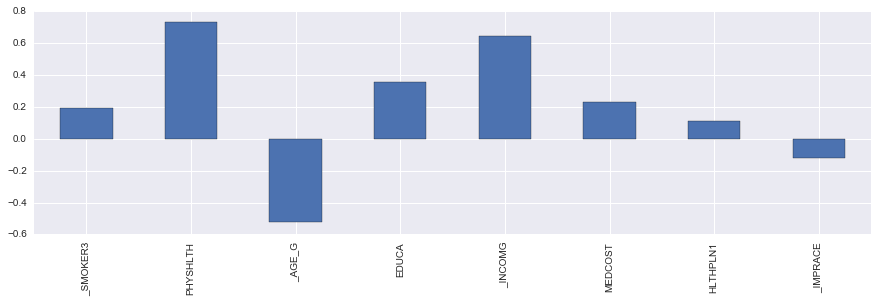

In [13]:
plt.figure(figsize=[15,4])

weights = pd.Series(logReg.coef_[0],index=df_logreg.columns)
weights.plot(kind='bar')
plt.show()

## Gradient Boosting Regression

MSE: 0.0859


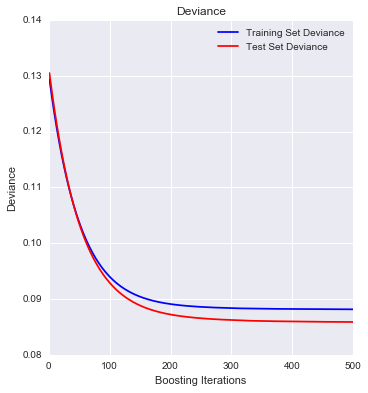

In [108]:
# code built from: 
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

###############################################################################
# Load data
X, y = shuffle(df_reduced1.PHYSHLTH.reshape(-1,1), df_reduced1.health.ravel(), random_state=13)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
